In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from glob import glob
import pickle
import tensorflow as tf

In [2]:
import os
import keras

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.18.0


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="6DUZXUzEElvb164kQwwY")
project = rf.workspace("pingworkspace").project("txlpbc-v2-vnadh")
version = project.version(1)
dataset = version.download("voc")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to txlpbc-v2-1 in voc:: 100%|██████████| 815/815 [00:00<00:00, 8065.78it/s]


In [4]:
data_path = 'txlpbc-v2-1/'

train_path = "txlpbc-v2-1/train/"

valid_path = "txlpbc-v2-1/valid/"

test_path = "txlpbc-v2-1/test/"

In [5]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np

def class_name_to_id(class_name):
    class_map = {
        'PC': 0,  # Replace with actual class names
        'RBC': 1,
        'WBC': 2,
    }
    return class_map.get(class_name, -1)  # Default to -1 for unknown classes

def parse_xml(xml_file, image_shape, num_classes=3):
    # Initialize mask (2D) where 0 represents background
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_id = class_name_to_id(class_name)  # Assuming function to map class names to ids

        polygon = obj.find('polygon')
        if polygon is not None:
            # Extract polygon points
            points = []
            i = 1
            while True:
                x = polygon.find(f'x{i}')
                y = polygon.find(f'y{i}')
                if x is None or y is None:
                    break  # Exit if no more points
                points.append([int(float(x.text)), int(float(y.text))])
                i += 1

            if points:
                # Convert points list to a proper format for OpenCV (Nx2 array)
                points = np.array(points, dtype=np.int32)
                points = points.reshape((-1, 1, 2))  # Reshape to required format for fillPoly

                # Fill the polygon on the mask with the class ID
                cv2.fillPoly(mask, [points], class_id)

        else:
            # Fallback to bounding box if polygon is not available
            bbox = obj.find('bndbox')
            if bbox is not None:
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                # Draw class_id into the bounding box area of the mask
                mask[ymin:ymax, xmin:xmax] = class_id

    return mask

def make_dataset(image_dir, num_classes=3):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            xml_path = os.path.join(image_dir, filename[:-4] + '.xml')  # Use the same filename for the XML

            # Read and resize the image to 224x224
            image = cv2.resize(cv2.imread(image_path), (224, 224))  # Assuming input size is 224x224
            images.append(image)

            # Parse the corresponding XML file to create the mask
            mask = parse_xml(xml_path, image.shape, num_classes)
            mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks

In [6]:
X_train, y_train = make_dataset(train_path)
X_val, y_val = make_dataset(valid_path)
X_test, y_test = make_dataset(test_path)

In [7]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

(<Axes: >,
 (np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5)))

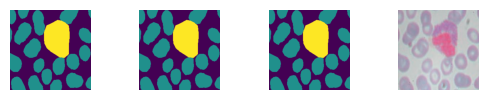

In [8]:
from matplotlib.gridspec import GridSpec
from random import randint, sample
ranidx = randint(0, len(y_train))
gs = GridSpec(4,4)
plt.figure(dpi=100)
for i in range(3):
    plt.subplot(gs[i]), plt.imshow(y_train[ranidx][:,:]), plt.axis('off')

plt.subplot(gs[3]), plt.imshow(X_train[ranidx]), plt.axis('off')

In [9]:
num_classes = 3
input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8

In [10]:
IMAGE_SIZE = 224
num_classes = 3
batch = 16
LR = 1e-4
EPOCHS = 200

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(.5, .2),
  layers.RandomContrast(0.1)],
  )

In [12]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x

 # Function to generate tensorflow dataset
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

train_dataset = tf_dataset_train(X_train, y_train)
valid_dataset = tf_dataset_valid(X_val, y_val)
test_dataset = tf_dataset_valid(X_test, y_test)

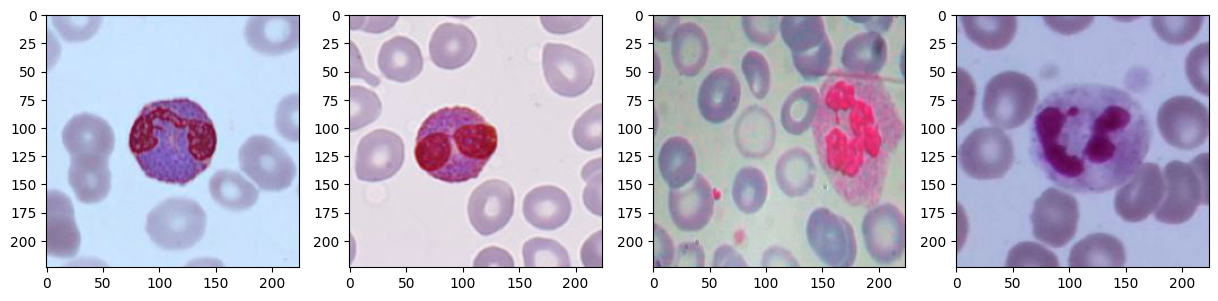

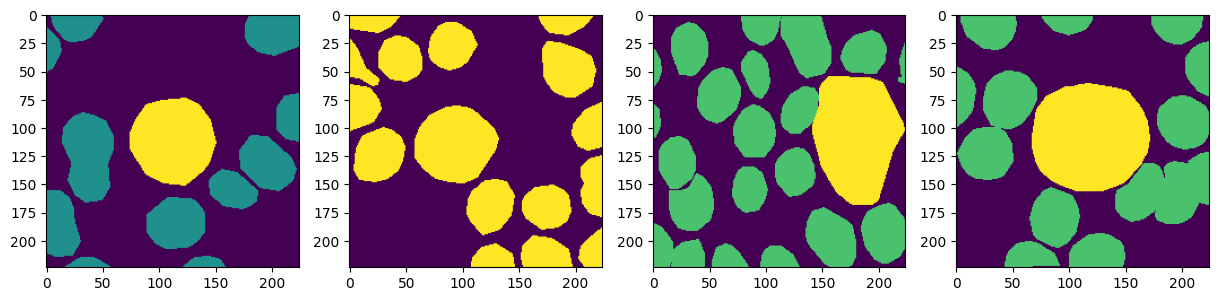

In [13]:
# def read_and_rgb(x):
#     x = cv2.imread(x)
#     x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
#     return x

# Plot samples of images and corresponding masks
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[1])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[2])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[3])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[1])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[2])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[3])
imgplot.set_clim(0.0, 1.4)

In [14]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=151):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [15]:
model = unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=151)

# Specify all the encoder layers in a list
encoder_layers = model.layers[0:-22]

# Freeze the encoder layers for transfer learning (so that weights are only changed for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False
    print(layer, layer.trainable)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<InputLayer name=input_image, built=True> False
<Conv2D name=Conv1, built=True> False
<BatchNormalization name=bn_Conv1, built=True> False
<ReLU name=Conv1_relu, built=True> False
<DepthwiseConv2D name=expanded_conv_depthwise, built=True> False
<BatchNormalization name=expanded_conv_depthwise_BN, built=True> False
<ReLU name=expanded_conv_depthwise_relu, built=True> False
<Conv2D name=expanded_conv_project, built=True> False
<BatchNormalization name=expanded_conv_project_BN, built=True> False
<Conv2D name=block_1_expand, built=True> False
<BatchNormalization name=block_1_expand_BN, built=True> False
<ReLU name=block_1_expand_relu, built=True> False
<ZeroPadding2D name=block_1_pad, built=True> False
<DepthwiseConv2D name=block_1_depthwise, built=True> False
<BatchNormalization name=block_1_depthwise_BN, built=True> False
<ReLU name=block_1_depthwise_relu, built=True> False
<Conv2D name=bl

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,635,223 (17.68 MB)

 Trainable params: 4,017,495 (15.33 MB)

 Non-trainable params: 617,728 (2.36 MB)

In [16]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=151)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [17]:
opt = tf.keras.optimizers.Adam(LR)
metrics = [dice_coef, 'accuracy']
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [18]:
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=200,
                    shuffle=True)

Epoch 1/200


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InternalError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/errors_impl.py(462): __init__
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/context.py(1683): call_function
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(919): _call
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py(219): function
  /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py(371): fit
  /usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py(117): error_handler
  /tmp/ipython-input-18-4273747946.py(1): <cell line: 0>
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3553): run_code
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3473): run_ast_nodes
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3257): run_cell_async
  /usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3030): _run_cell
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(2975): run_cell
  /usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py(528): run_cell
  /usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py(383): do_execute
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(730): execute_request
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(499): process_one
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /usr/lib/python3.11/asyncio/events.py(84): _run
  /usr/lib/python3.11/asyncio/base_events.py(1936): _run_once
  /usr/lib/python3.11/asyncio/base_events.py(608): run_forever
  /usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py(205): start
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py(712): start
  /usr/local/lib/python3.11/dist-packages/traitlets/config/application.py(992): launch_instance
  /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py(37): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


In [ ]:
history.history.keys()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test, verbose=1)

ranidx = randint(0, len(y_test))
gs = GridSpec(1,12)
plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(pred[ranidx][:,:,i], cmap='jet'), plt.axis('off')

plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(y_test[ranidx][:,:],cmap='jet'), plt.axis('off')

plt.figure(),plt.imshow(X_test[ranidx]), plt.axis('off')

In [ ]:
# refer from : https://github.com/preddy5/segnet/blob/master/Segnet.ipynb
#RBC = [128,128,128]
RBC = [128,0,0]
# Building = [128,0,0]
# Pole = [192,192,128]
# Road_marking = [255,69,0]
# Road = [128,64,128]
# Pavement = [60,40,222]
# WBC = [128,128,0]
WBC = [60,40,222]
# SignSymbol = [192,128,128]
# Fence = [64,64,128]
PC = [64,0,128]
# Pedestrian = [64,64,0]
# Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

#label_colours = np.array([RBC, WBC, PC, Unlabelled])
label_colours = np.array([Unlabelled,RBC, WBC, PC])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in [0, 1, 2]:
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

# randsample = sample(range(0,len(pred)), 4)
randsample = [0, 1, 2, 3]
gs = GridSpec(3,5)
plt.figure(dpi=200)

for i in range(4):
    output = visualize(np.argmax(pred[randsample[i]],axis=2).reshape((224,224)), plot=False)
    #out_test = visualize(np.argmax(y_test[randsample[i]],axis=2).reshape((224,224)), plot=False)

    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5+i]), plt.imshow(output), plt.axis('off')
    #plt.subplot(gs[10+i]), plt.imshow(out_test), plt.axis('off')